In [73]:
from collections import defaultdict
import torch 
import torchvision
import numpy as np
from numpy.linalg import pinv
import torchvision.models as models
from utils.celeba_dataset import CelebADataset, get_celeba_transforms
from utils.lfw_dataset import LFWDataset, get_lfw_transforms
import matplotlib.pyplot as plt

In [6]:
net = models.resnet18(pretrained=True)
net = net.cuda()
batch_size=1000

# Celeba

In [7]:
attr_file = "/projects/grail/jpgard/celeba/anno/list_attr_celeba.txt"
partition_file = "/projects/grail/jpgard/celeba/eval/list_eval_partition.txt"
root_dir = "/projects/grail/jpgard/celeba/img/img_align_celeba"
target_colname = "Smiling"
attribute_colname = "Blond_Hair"
transforms = get_celeba_transforms('train')

dset = CelebADataset(attr_file,
                    partition_file,
                    root_dir,
                    target_colname,
                    attribute_colname,
                    transforms)

dset_attr_pos = CelebADataset(attr_file,
                    partition_file,
                    root_dir,
                    target_colname,
                    attribute_colname,
                    transforms,
                    train_attribute_subset=1)

dset_attr_neg = CelebADataset(attr_file,
                    partition_file,
                    root_dir,
                    target_colname,
                    attribute_colname,
                    transforms,
                    train_attribute_subset=0)

[DEBUG] attribute values in train dataset:
0    138503
1     24267
Name: Blond_Hair, dtype: int64
[DEBUG] attribute values in train dataset:
1    24267
Name: Blond_Hair, dtype: int64
[DEBUG] attribute values in train dataset:
0    138503
Name: Blond_Hair, dtype: int64


In [8]:

celeba_loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, 
                                     num_workers=2, 
                                     drop_last=True)
celeba_loader_attr_pos = torch.utils.data.DataLoader(dset_attr_pos, batch_size=batch_size, shuffle=False, 
                                     num_workers=2, 
                                     drop_last=True)
celeba_loader_attr_neg = torch.utils.data.DataLoader(dset_attr_neg, batch_size=batch_size, shuffle=False, 
                                     num_workers=2, 
                                     drop_last=True)

In [138]:
def encode_dataset(loader, net, loader_elems=3):
    encoded_batches = list()
    for i, data in enumerate(loader):
        if loader_elems == 3:
            images, idxs, labels = data
        else:
            images, labels = data
        if i % 10 == 0:
            print(i)
        encoded = net(images.cuda())
        encoded = encoded.cpu().detach().numpy()
        encoded = np.squeeze(encoded)
        encoded = np.reshape(encoded, (encoded.shape[0], -1))
        encoded_batches.append(encoded)
        del images
        torch.cuda.empty_cache()
    encoded_dset = np.vstack(encoded_batches)
    return encoded_dset

In [10]:
celeba_encoded = encode_dataset(celeba_loader, net)
celeba_attr0_encoded = encode_dataset(celeba_loader_attr_neg, net)
celeba_attr1_encoded = encode_dataset(celeba_loader_attr_pos, net)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
0
10
20
30
40
50
60
70
80
90
100
110
120
130
0
10
20


In [ ]:
H_celeba = np.cov(celeba_encoded, rowvar=False)
H_0_celeba = np.cov(celeba_attr0_encoded, rowvar=False)
H_1_celeba = np.cov(celeba_attr1_encoded, rowvar=False)

In [149]:
def trprod(A, B):
    return np.trace(np.matmul(A, B))

def trinv(A):
    return np.trace(pinv(A))

def h_diagnostics(H, H_1, H_2, n=50):
    H_inv = pinv(H)
    H_minus2 = np.matmul(H_inv, H_inv)
    print("Tr(H1*H^-1) is {}".format(trprod(H_1, H_inv)))
    print("Tr(H2*H^-1) is {}".format(trprod(H_2, H_inv)))
    print("Tr(H1*H^-2) is {}".format(trprod(H_1, H_minus2)))
    print("Tr(H2*H^-2) is {}".format(trprod(H_2, H_minus2)))
    print("Tr(H1^-1) is {}".format(trinv(H_1)))
    print("Tr(H2^-1) is {}".format(trinv(H_2)))
    # plot singular values of H1 and H2 and H.
    plt.figure(figsize=(15,9))
    s = np.linalg.svd(H, compute_uv=False)
    s_1 = np.linalg.svd(H_1, compute_uv=False)
    s_2 = np.linalg.svd(H_2, compute_uv=False)
    plt.plot(s[:n], color='blue', label="H")
    plt.plot(s_1[:n], color='orange', label="H_1")
    plt.plot(s_2[:n], color='black', label="H_2")
    plt.legend()
    plt.title("Singular Values of Covariance Matrices")

Tr(H1*H^-1) is 811.3207029253244
Tr(H2*H^-1) is 810.8464471101761
Tr(H1*H^-2) is 265292350881792.0
Tr(H2*H^-2) is 261664535871488.0
Tr(H1^-1) is 244289948170308.94
Tr(H2^-1) is 226501273783782.0


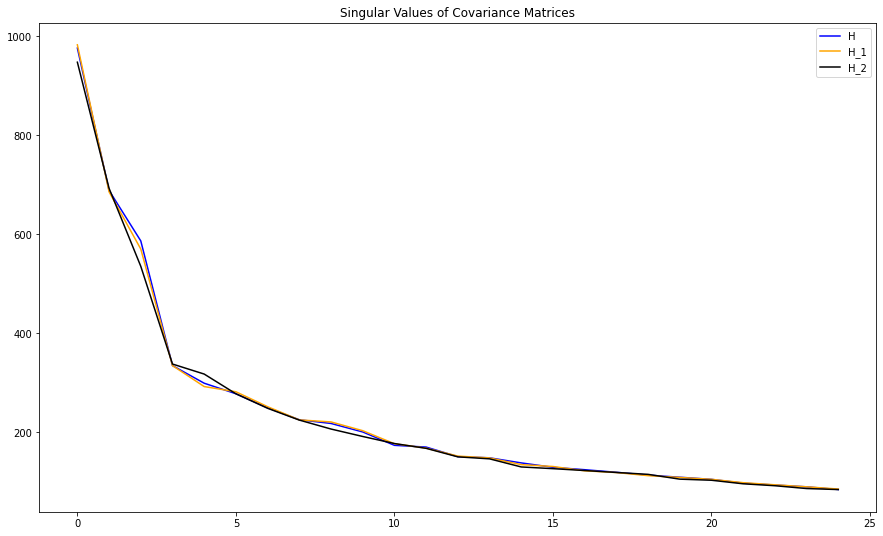

In [150]:
h_diagnostics(H_celeba, H_0_celeba, H_1_celeba, 25)

Text(0.5, 0.98, 'Celeba Covariance Matrices')

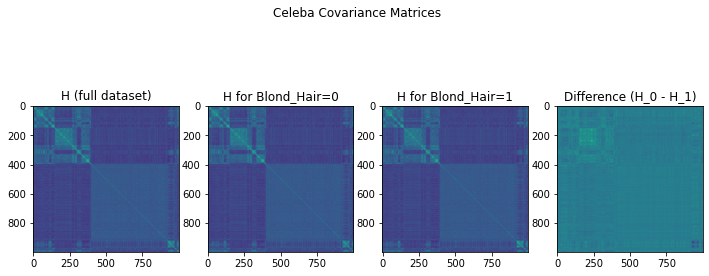

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1, 4, 1)
plt.imshow(H_celeba)
plt.title("H (full dataset)")
plt.subplot(1,4,2)
plt.imshow(H_0_celeba)
plt.title("H for {}=0".format(attribute_colname))
plt.subplot(1,4,3)
plt.imshow(H_1_celeba)
plt.title("H for {}=1".format(attribute_colname))
plt.subplot(1,4,4)
plt.imshow(H_0_celeba - H_1_celeba)
plt.title("Difference (H_0 - H_1)")
plt.suptitle("Celeba Covariance Matrices")

# LFW

In [14]:
target_colname = "Smiling"
attribute_colname = "Black"
root_dir = "/projects/grail/jpgard/lfw/"
label_threshold = 0.3
lfw_transforms = get_lfw_transforms('train', normalize=True)
lfw_dset = LFWDataset(root_dir, target_colname, attribute_colname, label_threshold, lfw_transforms)
lfw_loader = torch.utils.data.DataLoader(lfw_dset, batch_size=batch_size, shuffle=False, 
                                     num_workers=2, 
                                     drop_last=True)

def idx_where_true(ary):
    return np.ravel(np.argwhere(ary.values))

In [15]:
encoded_batches = defaultdict(list)
for i, (images, idxs, labels) in enumerate(lfw_loader):
    if i % 10 == 0:
        print(i)
    encoded = net(images.cuda())
    encoded = encoded.cpu().detach().numpy()
    attr_labels = lfw_loader.dataset.get_attribute_annotations(idxs)
    pos_attr_idxs = idx_where_true(attr_labels == 1)
    neg_attr_idxs = idx_where_true(attr_labels == 0)
    encoded_batches["0"].append(encoded[neg_attr_idxs, ...])
    encoded_batches["1"].append(encoded[pos_attr_idxs, ...])
    encoded_batches["01"].append(encoded)
    del images
    torch.cuda.empty_cache()

0


In [16]:
H_lfw = np.cov(np.vstack(encoded_batches["01"]), rowvar=False)
H_0_lfw = np.cov(np.vstack(encoded_batches["0"]), rowvar=False)
H_1_lfw = np.cov(np.vstack(encoded_batches["1"]), rowvar=False)

Text(0.5, 0.98, 'LFW Covariance Matrices')

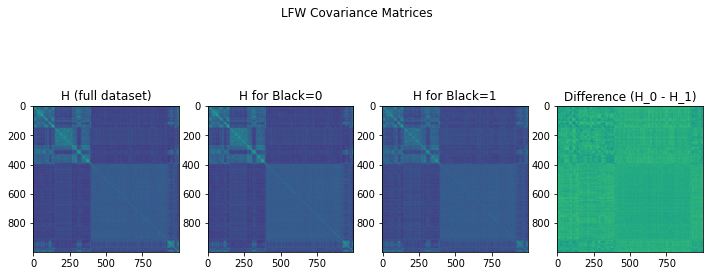

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1, 4, 1)
plt.imshow(H_lfw)
plt.title("H (full dataset)")
plt.subplot(1,4,2)
plt.imshow(H_0_lfw)
plt.title("H for {}=0".format(attribute_colname))
plt.subplot(1,4,3)
plt.imshow(H_1_lfw)
plt.title("H for {}=1".format(attribute_colname))
plt.subplot(1,4,4)
plt.imshow(H_0_lfw - H_1_lfw)
plt.title("Difference (H_0 - H_1)")
plt.suptitle("LFW Covariance Matrices")

Tr(H1*H^-1) is 679.7997273206711
Tr(H2*H^-1) is 795.2310123443604
Tr(H1*H^-2) is 133244983607296.0
Tr(H2*H^-2) is 160898173632512.0
Tr(H1^-1) is 131161886474218.1
Tr(H2^-1) is 94.30682743026254


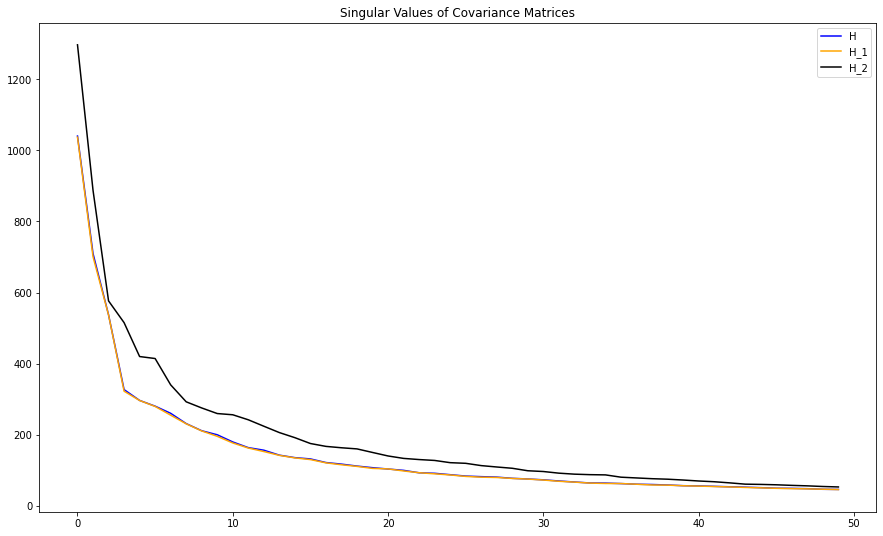

In [151]:
h_diagnostics(H_lfw, H_0_lfw, H_1_lfw)

# MNIST/CIFAR Mashup

In [93]:
from torchvision import transforms 
def get_filtered_dset(label, dset_name, new_label, max_n=5000):
    print(label)
    print(dset_name)
    if dset_name == "mnist":
        t = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(3, 1, 1) )])
        dset = torchvision.datasets.MNIST(root="./data", train=True, transform=t)
    elif dset_name == "cifar10":
        t = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
        dset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=t)
        
    else:
        raise NotImplementedError
    idx = [i for i,t in enumerate(dset.targets) if t == label][:max_n]
    trainset = torch.utils.data.Subset(dset, idx)
    print("%s elems" % len(trainset))
    return trainset


def build_dataset():
    """Create a dataset where label zero is (MNIST 0 + CIFAR10 ship) and label one is (MNIST 1 + CIFAR10 ship)."""
    mnist_zeros = get_filtered_dset(0, "mnist", new_label=0)
    mnist_ones = get_filtered_dset(1, "mnist", new_label=1)
    # See https://www.cs.toronto.edu/~kriz/cifar.html
    # 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    cifar_ship = get_filtered_dset(8, "cifar10", new_label=0)
    cifar_frog = get_filtered_dset(6, "cifar10", new_label=1)
    pos_class_dsets = [mnist_zeros, cifar_ship]
    neg_class_dsets = [mnist_ones, cifar_frog]
    minority_dsets = [mnist_zeros, mnist_ones]
    majority_dsets = [cifar_ship, cifar_frog]
    dset = torch.utils.data.ConcatDataset(pos_class_dsets + neg_class_dsets)
    minority_dset = torch.utils.data.ConcatDataset(minority_dsets)
    majority_dset = torch.utils.data.ConcatDataset(majority_dsets)
    return dset, minority_dset, majority_dset

mashup_dset, mashup_dset_minority, mashup_dset_majority = build_dataset()

0
mnist
5000 elems
1
mnist
5000 elems
8
cifar10
5000 elems
6
cifar10
5000 elems


In [146]:
minority_loader = torch.utils.data.DataLoader(mashup_dset_minority, batch_size=batch_size, shuffle=True, 
                                     num_workers=2, 
                                     drop_last=True)
mashup_minority_encoded = encode_dataset(minority_loader, net, loader_elems=2)

majority_loader = torch.utils.data.DataLoader(mashup_dset_majority, batch_size=batch_size, shuffle=True, 
                                     num_workers=2, 
                                     drop_last=True)
mashup_majority_encoded = encode_dataset(majority_loader, net, loader_elems=2)

mashup_loader = torch.utils.data.DataLoader(mashup_dset, batch_size=batch_size, shuffle=True, 
                                     num_workers=2, 
                                     drop_last=True)
mashup_encoded = encode_dataset(mashup_loader, net, loader_elems=2)

0
0
0
10


In [147]:
H_mashup = np.cov(mashup_encoded, rowvar=False)
H_0_mashup = np.cov(mashup_majority_encoded, rowvar=False)
H_1_mashup = np.cov(mashup_minority_encoded, rowvar=False)

Tr(H1*H^-1) is 682.8966863453388
Tr(H2*H^-1) is 680.1947886850685
Tr(H1*H^-2) is 32225709522944.0
Tr(H2*H^-2) is 31804661399552.0
Tr(H1^-1) is 52480204886430.18
Tr(H2^-1) is 35388195948610.25


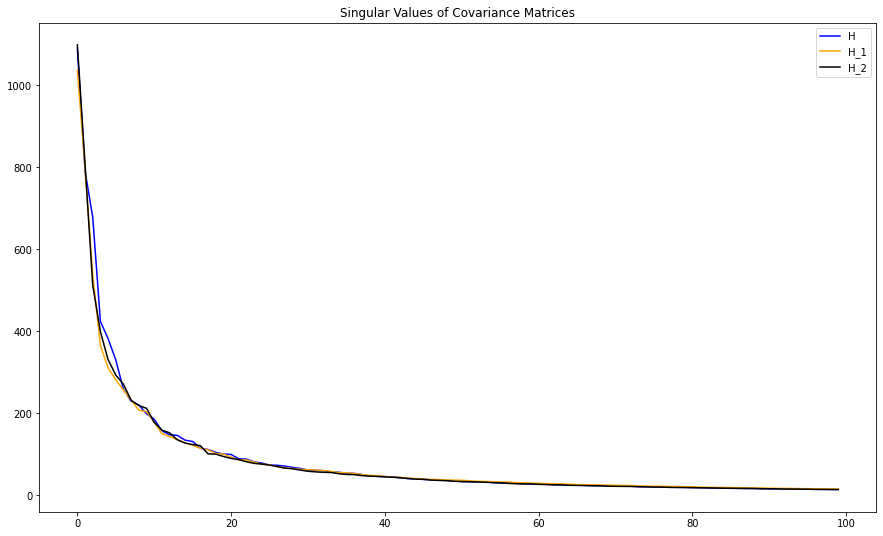

In [156]:
h_diagnostics(H_mashup, H_0_mashup, H_1_mashup, 100)

In [157]:
np.trace(np.matmul(H_1_mashup, H_1_mashup))

2991150.949988737

In [158]:
np.trace(np.matmul(H_1_mashup, H_0_mashup))

2690300.5046192105

In [159]:
np.trace(np.matmul(H_0_mashup, H_0_mashup))

2816067.9250020273

In [142]:
net_conv = torch.nn.Sequential(*list(net.children())[:-1])

In [121]:
x, _, _ = next(iter(celeba_loader))
e = net_conv(x.cuda())

In [162]:
H = H_mashup
H_0 = H_0_mashup
H_1 = H_1_mashup

H_inv = pinv(H)
H_minus2 = np.matmul(H_inv, H_inv)
# print("Tr(H1*H^-1) is {}".format(trprod(H_1, H_inv)))
# print("Tr(H2*H^-1) is {}".format(trprod(H_2, H_inv)))
# print("Tr(H1*H^-2) is {}".format(trprod(H_1, H_minus2)))
# print("Tr(H2*H^-2) is {}".format(trprod(H_2, H_minus2)))
# print("Tr(H1^-1) is {}".format(trinv(H_1)))
# print("Tr(H2^-1) is {}".format(trinv(H_2)))

np.trace((H_0 - H_1)*pinv(H)*pinv(H))

6.059902108914006e+23

In [163]:
np.trace((H_0 - H_1)*pinv(H))

8541379723948.957

In [164]:
np.trace((H_0 - H_1)*pinv(H)*pinv(H)) / np.trace((H_0 - H_1)*pinv(H))

70947578784.2894